In [1]:
import sys, os

project_root = os.path.abspath(os.path.join(".."))
if project_root not in sys.path:
    sys.path.append(project_root)


In [2]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from src.data_loader import get_data_loaders
from src.transfer_model import build_mobilenetv2_transfer_model


In [3]:
train_gen, val_gen, test_gen = get_data_loaders()


Found 23565 images belonging to 2 classes.
Found 3750 images belonging to 2 classes.
Found 3750 images belonging to 2 classes.


In [4]:
model, base_model = build_mobilenetv2_transfer_model()
model.load_weights("models/mobilenetv2_phase1.h5")


In [5]:
# Unfreeze last 25 layers of the base model
fine_tune_at = len(base_model.layers) - 25

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True


In [6]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


In [7]:
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        "models/mobilenetv2_finetuned.h5",
        monitor="val_accuracy",
        save_best_only=True
    )
]

history_finetune = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
1473/1473 [==============================] - 632s 427ms/step - loss: 0.1153 - accuracy: 0.9563 - val_loss: 0.0416 - val_accuracy: 0.9843


c:\Users\rakes\anaconda3\envs\tf_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/10
1473/1473 [==============================] - 693s 471ms/step - loss: 0.0830 - accuracy: 0.9686 - val_loss: 0.0268 - val_accuracy: 0.9915
Epoch 3/10
1473/1473 [==============================] - 693s 470ms/step - loss: 0.0657 - accuracy: 0.9754 - val_loss: 0.0263 - val_accuracy: 0.9896
Epoch 4/10
1473/1473 [==============================] - 679s 461ms/step - loss: 0.0581 - accuracy: 0.9776 - val_loss: 0.0210 - val_accuracy: 0.9920
Epoch 5/10
1473/1473 [==============================] - 667s 453ms/step - loss: 0.0535 - accuracy: 0.9801 - val_loss: 0.0203 - val_accuracy: 0.9941
Epoch 6/10
1473/1473 [==============================] - 667s 453ms/step - loss: 0.0509 - accuracy: 0.9810 - val_loss: 0.0183 - val_accuracy: 0.9936
Epoch 7/10
1473/1473 [==============================] - 693s 471ms/step - loss: 0.0439 - accuracy: 0.9831 - val_loss: 0.0184 - val_accuracy: 0.9944
Epoch 8/10
1473/1473 [==============================] - 673s 457ms/step - loss: 0.0406 - accuracy: 0.9856 - val_

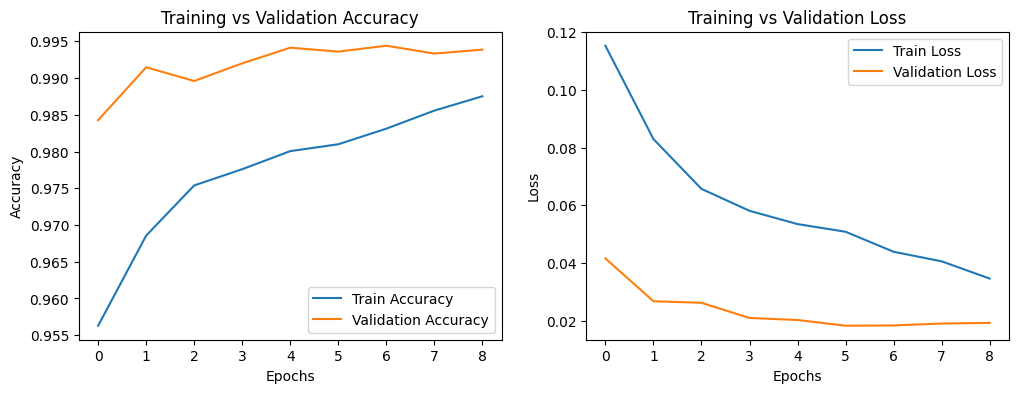

In [15]:
import matplotlib.pyplot as plt
from pathlib import Path
import os

PROJECT_ROOT = Path(os.getcwd()).parent
REPORTS_DIR = PROJECT_ROOT / "reports"
REPORTS_DIR.mkdir(exist_ok=True)

# Create figure
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_finetune.history["accuracy"], label="Train Accuracy")
plt.plot(history_finetune.history["val_accuracy"], label="Validation Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_finetune.history["loss"], label="Train Loss")
plt.plot(history_finetune.history["val_loss"], label="Validation Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Save plot
plt.savefig(REPORTS_DIR / "training_curves.png", dpi=300, bbox_inches="tight")
plt.show()


In [16]:
import os
os.path.exists("../reports/training_curves.png")


True

### Phase 2: Fine-Tuning

Fine-tuning was performed by unfreezing only the top layers of the MobileNetV2
backbone while keeping lower layers frozen. A very small learning rate was used
to adapt high-level features to the Cats vs Dogs dataset without catastrophic
forgetting of pre-trained ImageNet knowledge.
